In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import networkx as nx
import numpy as np
%matplotlib inline

In [11]:
plt.rcParams['figure.figsize'] = 15, 8
# plt.rcParams['font.family'] = 'DejaVu Serif'
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 18
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 18

# Task 7

In [8]:
G = nx.read_adjlist("graph.txt", nodetype=int, create_using=nx.DiGraph())

**Проверим, что при считывании не потерялись условия задачи**

In [9]:
len(G.edges)

5105039

In [10]:
len(G.nodes)

875713

In [11]:
nx.is_directed(G)

True

In [12]:
from collections import defaultdict

def get_degrees_distr(G: nx.Graph):
    degrees = defaultdict(int)

    for v in G.nodes():
        d = G.degree(v)
        degrees[d] += 1
    return degrees

In [13]:
degrees = get_degrees_distr(G)

In [20]:
_degrees, _amounts = zip(*sorted(degrees.items(), key=lambda x: x[0]))

In [25]:
cumulative_amounts = np.array(_amounts).cumsum()

In [26]:
cumulative_dict = {k: v for k, v in zip(_degrees, cumulative_amounts)} 

In [31]:
def plot_degrees(degrees: defaultdict, _type=None):
    plt.loglog(degrees.keys(), degrees.values(), ls=None, marker='.')
    if _type is None:
        plt.title("Распределение степеней вершин")  
        plt.ylabel("Число вершин")
    else:
        plt.title(f"{_type} распределение степеней вершин")  
        plt.ylabel(f"{_type} число вершин")
    plt.xlabel("Полная cтепень вершины")

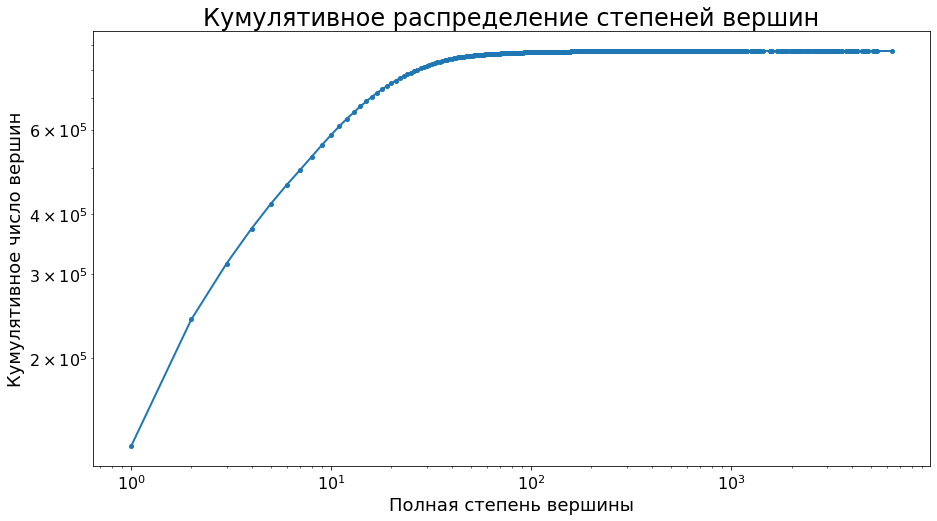

In [103]:
plot_degrees(cumulative_dict, _type="Кумулятивное")

In [130]:
from scipy.optimize import curve_fit

power_law = lambda d, c, gamma: c / (d**gamma)

_degrees = np.array(_degrees)
main_part_mask = (_degrees < np.quantile(_degrees, 0.03)) & (_degrees >= 1)
opt_params, opt_covar = curve_fit(power_law, _degrees[main_part_mask], cumulative_amounts[main_part_mask])

In [131]:
cumulative_amounts[main_part_mask]

array([130912, 240887, 315135, 372868, 420174, 460112, 494511, 527222,
       557590, 585054, 610277, 632700, 652445, 670909, 687583, 702860,
       716588, 728608, 739713, 750075, 759430, 767911, 775635],
      dtype=int32)

In [132]:
opt_params

array([ 2.03618063e+05, -4.41557998e-01])

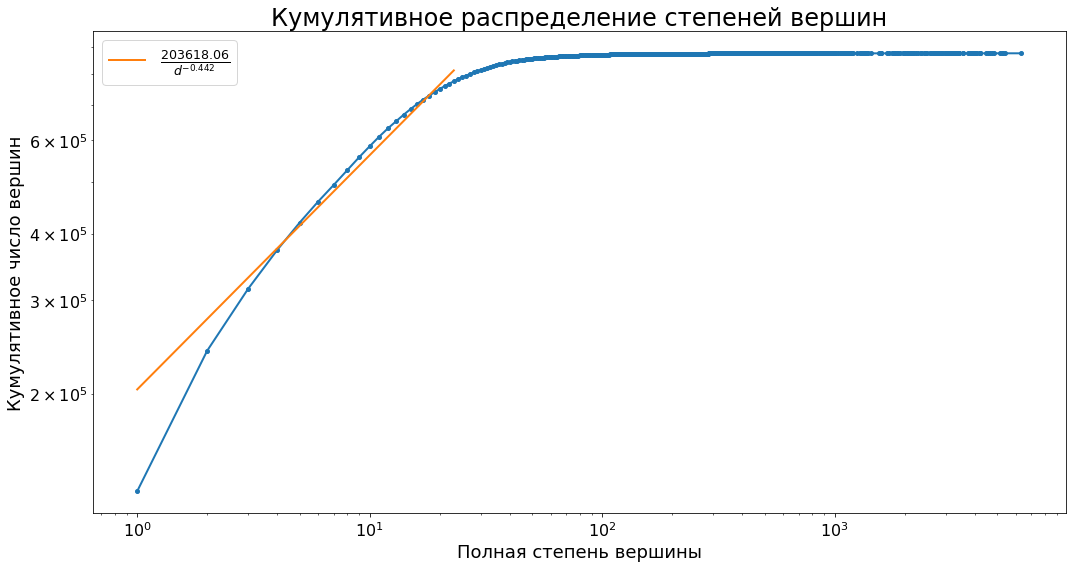

In [133]:
plot_degrees(cumulative_dict, _type="Кумулятивное")
plt.loglog(_degrees[main_part_mask], 
           power_law(_degrees[main_part_mask],
                     opt_params[0], opt_params[1]), 
           label=r"$\frac{" + f"{opt_params[0]:.2f}" + "}{d^{" + f"{opt_params[1]:.3f}" + "}}$")
plt.legend()
plt.tight_layout()
plt.savefig("graph_6.jpg")

# Task 8

In [12]:
def J(A: set, B: set):
    return len(A.intersection(B)) / len(A.union(B))

In [13]:
def Jaccard(G: nx.Graph, e: (int, int)):
    N_u = set(G.neighbors(e[0]))
    N_v = set(G.neighbors(e[1]))
    return J(N_u, N_v)

In [14]:
def J_G(G: nx.Graph):
    edges_J = list(map(lambda x: Jaccard(G, x), G.edges))
    return np.mean(edges_J)
        

**Проверим на полном графе $K_4$. Должно быть 0.5**

In [15]:
G = nx.complete_graph(4)

In [16]:
J_G(G)

0.5

Отлично. Приступим к основному заданию

In [17]:
n = 300
_step = 0.05
p_range = np.arange(0, 1+_step, _step) 

In [18]:
from tqdm.notebook import tqdm

J_values = []
for p in tqdm(p_range):
    _G = nx.erdos_renyi_graph(n=n, p=p)
    J_values.append(J_G(_G))

  0%|          | 0/21 [00:00<?, ?it/s]

C:\Users\Georgy\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Georgy\Anaconda3\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


**Теоретическая оценка:** $$\frac{(n-2)\cdot p^2}{2\cdot(n-1)\cdot p-(n-2)\cdot p^2} = \frac{298\cdot p^2}{2\cdot299\cdot p - 298\cdot p^2}$$

C:\Users\Georgy\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


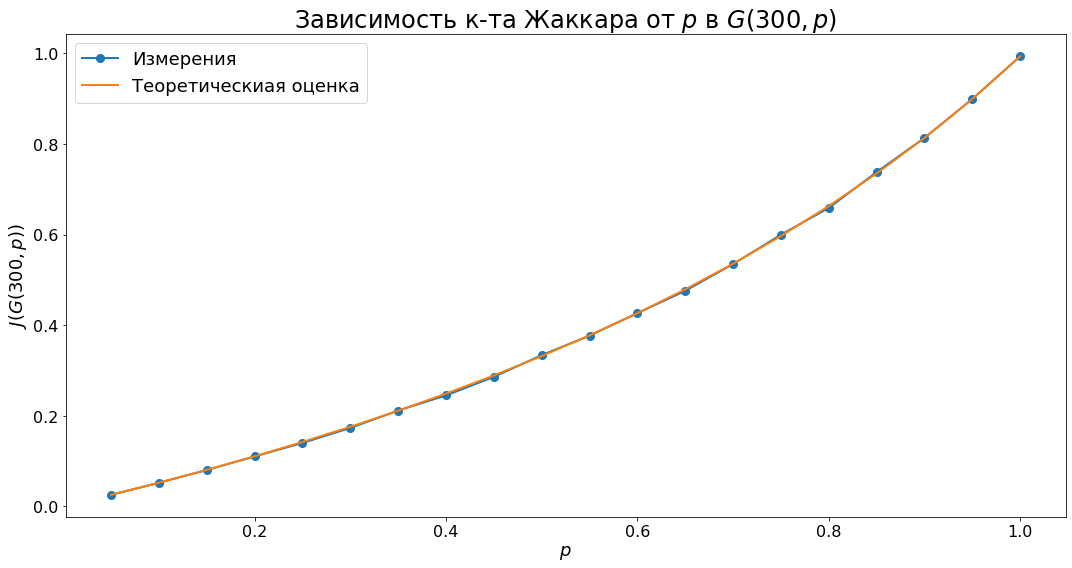

In [26]:
plt.plot(p_range, J_values, marker='o', label="Измерения")
_theory = lambda p: 298*p**2 / (598*p - 298*p**2)
plt.plot(p_range, _theory(p_range), alpha=1, label="Теоретическиая оценка")
plt.title(r"Зависимость к-та Жаккара от $p$ в $G(300, p)$")
plt.xlabel(r"$p$")
plt.ylabel(r"$J\left(G(300, p)\right)$")
plt.tight_layout()
plt.legend()
plt.savefig("graph_7.jpg")

# Task 9

Выбран блогер "varlamovru"

**Спарсим данные, если позволят)**

In [180]:
import requests

In [195]:
url = lambda x: f"https://www.livejournal.com/misc/fdata.bml?user={x}"

head_usr = "varlamovru"

with open("parsed_friends.txt", "w") as f:
    r = requests.get(url(head_usr), allow_redirects=True)
    contents_list = r.content.decode("utf-8").split('\n')
    contents_list = [c for c in contents_list if ">" in c or "<" in c]
    f.writelines([string.replace(">", f"{head_usr} ") + "\n" if ">" in string else
                  string.replace("< ", "") + f" {head_usr}" + "\n" 
                  for string in contents_list])
    
    unique_friends = np.unique([c.strip("<>") for c in contents_list])
    for friend in tqdm(unique_friends):
        r = requests.get(url(friend), allow_redirects=True)
        contents_list = r.content.decode("utf-8").split('\n')
        contents_list = [c for c in contents_list if ">" in c or "<" in c]
        f.writelines([string.replace(">", f"{friend} ") + "\n" if ">" in string else
                      string.replace("< ", "") + f" {friend}" + "\n" 
                      for string in contents_list])

  0%|          | 0/2781 [00:00<?, ?it/s]

Немного подчистим

In [3]:
with open("parsed_friends.txt", "r") as f:
    lines = f.readlines()

In [222]:
lines = [l.lstrip() for l in lines]

In [8]:
lines = np.unique(lines)

In [10]:
lines[0]

'00 hamal\n'

In [11]:
with open("parsed_friends.txt", "w") as f:
    f.writelines(lines)

**Теперь считаем**

In [3]:
G = nx.read_adjlist("parsed_friends.txt", nodetype=str, create_using=nx.DiGraph())

In [13]:
len(G.nodes)

333729

In [14]:
len(G.edges)

1645373

In [15]:
nx.is_directed(G)

True

In [18]:
print(f"Локальный кластерный коэффициент для {head_usr} = {nx.clustering(G, nodes=[head_usr])[head_usr]}")

Локальный кластерный коэффициент для varlamovru = 0.008826727372987425


In [19]:
print(f"Локальный кластерный коэффициент для {head_usr} = {nx.average_clustering(G, nodes=[head_usr])}")

Локальный кластерный коэффициент для varlamovru = 0.008826727372987425


In [7]:
head_usr = 'varlamovru'

In [8]:
G.degree(head_usr)

3024

**Визуализацию будем проводить через Gephi)**

Для визуализации из Topology Filter выбрано ограничение на диапазон степеней (иначе gephi выпадал) от 54 до 3846 (к сожалению, это отсекло некоторые другие вершины больших степеней). Как видно выше, varlamovru имеет не самую большую общую степень.
Кроме требуемых масштабов на размер подписей и вершин, также применена раскраска подписей и вершин в диапазонах, связанных с крупными степенями